In [1]:
import os
import re
import ctypes
import uproot
import numpy as np
import matplotlib.pyplot as plt

import ROOT

plt.rcParams["figure.figsize"] = (5, 3)

Welcome to JupyROOT 6.24/09


In [2]:
ROOT.gSystem.Load("/pbs/home/g/gdiazlop/Software/fiTQun/fiTQun/fQChrgPDF_cc.so")

def evaluate_logpdf(q, mus, npars):

    # values to be filled below
    par      = np.zeros(npars)
    muthr    = np.zeros(2)
    coeff    = np.zeros(6)

    # get parameters
    ROOT.fQChrgPDF.Get().SetCPDFParams( q, 0, ctypes.c_int(npars), par, muthr, coeff)

    # evaluate
    logpdf = []
    for mu in mus: logpdf.append(ROOT.fQChrgPDF.flogchrgPDF(mu, npars, par, muthr, coeff))
    logpdf = np.array(logpdf)

    return logpdf


# TODO: curve fit this
def get_fitting_function(mulow, muup):
    def func(mu, *pars):
        npars = len(pars)
        if (mulow<=mu) & (mu<=muup):
            return np.poly1d(np.flip(pars))(mu)
        elif (mu<mulow):
            c0 = sum([        pars[i]*mulow**i     for i in range(0, npars)])
            c1 = sum([i*      pars[i]*mulow**(i-1) for i in range(1, npars)])
            c2 = sum([i*(i-1)*pars[i]*mulow**(i-2)/2. for i in range(2, npars)])
            if (c2>0.): c2 = 0
            dmu = (mu-mulow)
            return c0 + dmu*(c1 + c2*dmu)
        elif (muup<mu):
            c0 = sum([        pars[i]*muup**i        for i in range(0, npars)])
            c1 = sum([i*      pars[i]*muup**(i-1)    for i in range(1, npars)])
            c2 = sum([i*(i-1)*pars[i]*muup**(i-2)/2. for i in range(2, npars)])
            if (c2>0.): c2 = 0
            # print(c0, c1, c2)
            dmu = (mu-muup)
            return c0 + dmu*(c1 + c2*dmu)
    return func

In [3]:
# o stands for "old"
ofname = os.path.expandvars("$HOME/Software/WCSimFQTuningTools/Charge/old_tools/fitpdf_type0.root")
fname  = os.path.expandvars("$HOME/Software/WCSimFQTuningTools/Charge/fitted_cpdf.root")

of = uproot.open(ofname)
f  = uproot.open(fname)

In [4]:
print(f.classnames())
print(of.classnames())

{'hCPDFrange_type0;1': 'TH1D', 'glogPDF_type0_Rang0_1;1': 'TGraph', 'glogPDF_type0_Rang0_2;1': 'TGraph', 'glogPDF_type0_Rang0_3;1': 'TGraph', 'glogPDF_type0_Rang0_4;1': 'TGraph', 'glogPDF_type0_Rang0_5;1': 'TGraph', 'glogPDF_type0_Rang0_6;1': 'TGraph', 'glogPDF_type0_Rang0_7;1': 'TGraph', 'glogPDF_type0_Rang0_8;1': 'TGraph', 'glogPDF_type0_Rang0_9;1': 'TGraph', 'glogPDF_type0_Rang0_10;1': 'TGraph', 'glogPDF_type0_Rang0_11;1': 'TGraph', 'glogPDF_type0_Rang0_12;1': 'TGraph', 'glogPDF_type0_Rang0_13;1': 'TGraph', 'glogPDF_type0_Rang0_14;1': 'TGraph', 'gParam_type0_Rang0_0;1': 'TGraph', 'gParam_type0_Rang0_1;1': 'TGraph', 'gParam_type0_Rang0_2;1': 'TGraph', 'gParam_type0_Rang0_3;1': 'TGraph', 'gmuthr_type0_Rang0_0;1': 'TGraph', 'gmuthr_type0_Rang0_1;1': 'TGraph', 'glogPDF_type0_Rang1_15;1': 'TGraph', 'glogPDF_type0_Rang1_16;1': 'TGraph', 'glogPDF_type0_Rang1_17;1': 'TGraph', 'glogPDF_type0_Rang1_18;1': 'TGraph', 'glogPDF_type0_Rang1_19;1': 'TGraph', 'glogPDF_type0_Rang1_20;1': 'TGraph', 'g

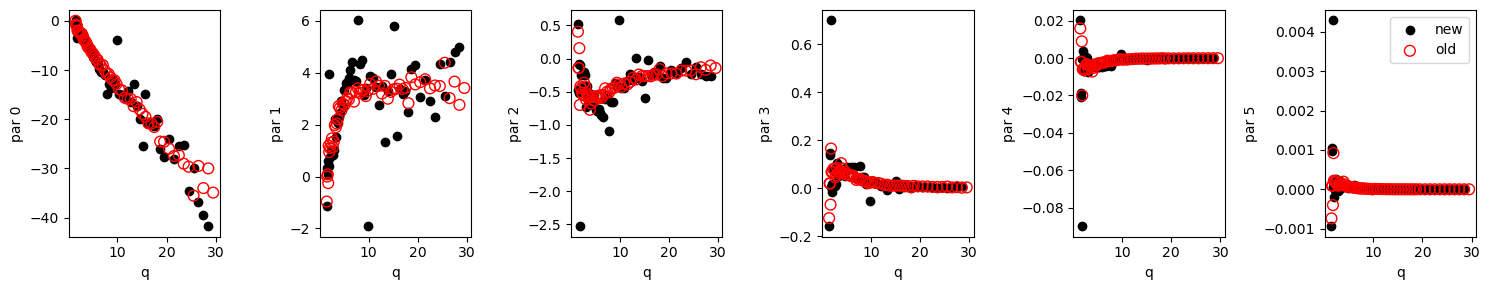

In [13]:
# compare gParams
rang = 1
npars, _ = f["hCPDFrange_type0"].to_numpy()
npars = int(npars[rang])

plt.figure(figsize=(15, 3))
for n in range(npars):
    qs, par   =  f[f"gParam_type0_Rang{rang}_{n}"].values()
    oqs, opar = of[f"gParam_type0_Rang{rang}_{n}"].values()

    plt.subplot(1, npars, n+1)
    plt.scatter( qs,  par, label="new", color="k")
    plt.scatter(oqs, opar, label="old", edgecolor="red", s=60, c="none")
    plt.xlabel(r"q")
    plt.ylabel(f"par {n}")
    # plt.xlim([0.1, None])
    # plt.ylim([-2, 2])
plt.legend()
plt.tight_layout()

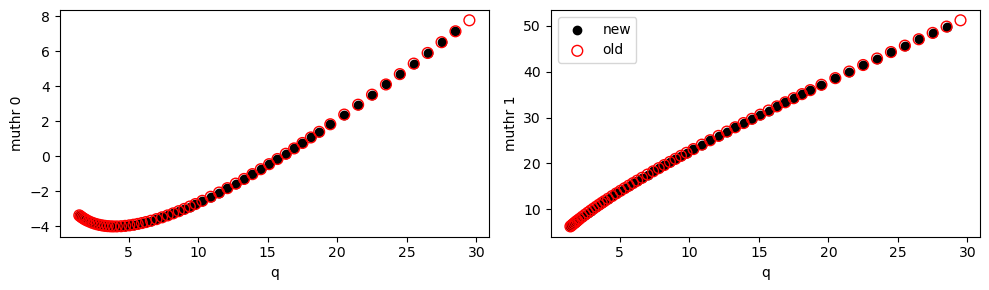

In [31]:
# compare muthrs
plt.figure(figsize=(10, 3))
for i in range(2):
    qs,  muthr  =  f[f"gmuthr_type0_Rang{rang}_{i}"].values()
    oqs, omuthr = of[f"gmuthr_type0_Rang{rang}_{i}"].values()

    plt.subplot(1, 2, i+1)
    plt.scatter( qs,  muthr, label="new", color="k")
    plt.scatter(oqs, omuthr, label="old", edgecolor="red", s=60, c="none")
    plt.xlabel(r"q")
    plt.ylabel(f"muthr {i}")
plt.legend()
plt.tight_layout()

In [29]:
# opdf = ROOT.fQChrgPDF.Get()
# opdf.LoadParams(ofname)

# pdf = ROOT.fQChrgPDF.Get()
# pdf.LoadParams(fname)

ROOT.fQChrgPDF.Get().LoadParams(fname)

fQChrgPDF: Loading parameters from /pbs/home/g/gdiazlop/Software/WCSimFQTuningTools/Charge/fitted_cpdf.root
P_unhit coeff. for Type 0 PMT: c_n=[0.086180, 0.011731, -0.001294, ]


q =  14.5
fQChrgPDF: Loading parameters from /pbs/home/g/gdiazlop/Software/WCSimFQTuningTools/Charge/fitted_cpdf.root
P_unhit coeff. for Type 0 PMT: c_n=[0.086180, 0.011731, -0.001294, ]
fQChrgPDF: Loading parameters from /pbs/home/g/gdiazlop/Software/WCSimFQTuningTools/Charge/old_tools/fitpdf_type0.root
P_unhit coeff. for Type 0 PMT: c_n=[0.094172, 0.004374, 0.000000, ]


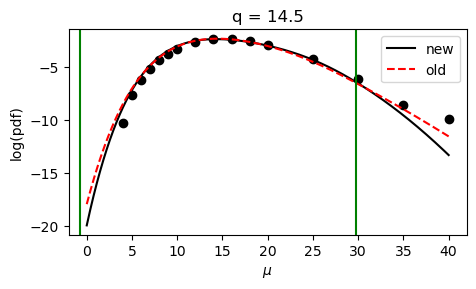

In [38]:
qindex = 40

print("q = ", qs[qindex])

# compute global index (note is different for old and new since old duplicates the boundaries)
rangindex0 = 0
for r in range(rang):
    qs, _ =  f[f"gmuthr_type0_Rang{r}_{i}"].values()
    rangindex0 += len(qs)
globalindex = rangindex0 + qindex + 1 + rang # old gobal index

# get parameters
pars  = []
opars = []
for n in range(npars):
    qs, par   =  f[f"gParam_type0_Rang{rang}_{n}"].values()
    oqs, opar = of[f"gParam_type0_Rang{rang}_{n}"].values()
    pars .append( par[qindex])
    opars.append(opar[qindex])
pars  = np.array(pars)
opars = np.array(opars)

omus, ologpdf = of[f"glogPDF_type0_Rang{rang}_{globalindex}"].values()

plt.figure()
plt.scatter(omus, ologpdf, color="k")

x = np.linspace(0, np.max(omus), 1000)

#new
ROOT.fQChrgPDF.Get().LoadParams(fname)
y = evaluate_logpdf(qs[qindex], x, npars)
plt.plot(x, y, color="k", label="new")

#old
ROOT.fQChrgPDF.Get().LoadParams(ofname)
y = evaluate_logpdf(oqs[qindex], x, npars)
plt.plot(x, y, color="r", label="old", linestyle="--")

# thresholds
for i in range(2):
    _,  muthr  =  f[f"gmuthr_type0_Rang{rang}_{i}"].values()
    _, omuthr = of[f"gmuthr_type0_Rang{rang}_{i}"].values()
    
    plt.axvline(muthr[qindex], color="g")

plt.title(f"q = {qs[qindex]}")
plt.xlabel(r"$\mu$")
plt.ylabel("log(pdf)")
plt.legend()
plt.tight_layout()

fQChrgPDF: Loading parameters from /pbs/home/g/gdiazlop/Software/WCSimFQTuningTools/Charge/old_tools/fitpdf_type0.root
P_unhit coeff. for Type 0 PMT: c_n=[0.094172, 0.004374, 0.000000, ]


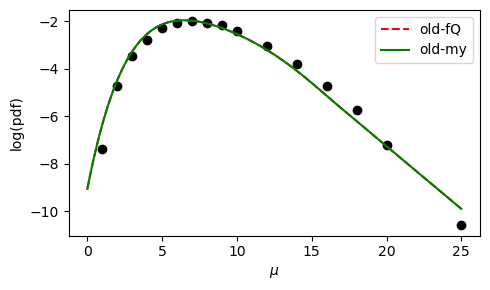

In [55]:
# Check same pdf fit function old-new

plt.figure()
plt.scatter(omus, ologpdf, color="k")

ROOT.fQChrgPDF.Get().LoadParams(ofname)
y = evaluate_logpdf(oqs[qindex], x, npars)
plt.plot(x, y, color="r", label="old-fQ", linestyle="--")

_, omuthr = of[f"gmuthr_type0_Rang{rang}_0"].values()
mulow = omuthr[qindex]
_, omuthr = of[f"gmuthr_type0_Rang{rang}_1"].values()
muup  = omuthr[qindex]
func = get_fitting_function(mulow, muup)
y = [func(mu, *opars) for mu in x]
plt.plot(x, y, color="g", label="old-my", linestyle="-")

plt.xlabel(r"$\mu$")
plt.ylabel("log(pdf)")
plt.legend()

plt.tight_layout()

In [63]:
pdf = ROOT.fQChrgPDF.Get()
pdf.LoadParams(ofname)

p_    = np.zeros(npars)
muthr = np.zeros(2)
coeff = np.zeros(6)

pdf.SetCPDFParams(qs[qindex], 0, ctypes.c_int(npars), p_, muthr, coeff)
coeff

array([ 0.80488152, -1.18209961,  0.        , -3.0190184 , -0.64935093,
       -0.01203552])

fQChrgPDF: Loading parameters from /pbs/home/g/gdiazlop/Software/WCSimFQTuningTools/Charge/old_tools/fitpdf_type0.root
P_unhit coeff. for Type 0 PMT: c_n=[0.094172, 0.004374, 0.000000, ]


In [65]:
func(6, *opars)

-3.019018400388627 -0.649350928978241 -0.0240710496638043


-5.410736097661167